In [1]:
import pandas as pd
import numpy as np
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt


In [2]:
data=pd.read_csv(r'C:\Users\kiran\OneDrive\Desktop\Shreya\KRR\home_kitchen.csv')

In [3]:
from sklearn.preprocessing import LabelEncoder

# Assuming 'ProductCategory' is a categorical column in your dataset
le = LabelEncoder()
data['Gender'] = le.fit_transform(data['Gender']) 
data['NewPrice']= 0
data= data.drop('ProductCategory', axis=1)

In [4]:

from sklearn.preprocessing import MinMaxScaler

# Assuming your dataset is stored in a DataFrame named 'data'
# and you want to normalize all columns

# Extract numerical columns (you might need to adjust this based on your data)
numerical_columns = data.select_dtypes(include=[np.number]).columns.tolist()

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the numerical columns
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])


In [5]:
state_features = ['Age', 'Gender', 'ProductPrice', 'ProductCost', 'Profit', 'FootTraffic', 'InventoryLevel', 'CompetitorPrice', 'PurchaseMonth', 'PurchaseQuarter', 'DayOfWeek','ProductType','NewPrice']
actions = [0.2, 0.15, -0.2, -0.15]

In [6]:
# Function to calculate reward for a given action
def calculate_reward_for_action(state, action, competitor_price_threshold=0.05, product_price_threshold=0.1):
   
    # Assuming 'ProductPrice' is at index 2 in the state array
    product_price_index = 2
    new_price_index=12
    penalty=0
    # Calculate new product price based on the action
    state[new_price_index] = state[product_price_index] * (1 + float(action))
    
    # Calculate profit
    profit = state[new_price_index] - state[3]  # Assuming 'ProductCost' is at index 4 in the state array
    
    # Check proximity to competitor price
    if abs(state[new_price_index] - state[7]) < competitor_price_threshold * state[7]:  # Assuming 'CompetitorPrice' is at index 8
        # Apply penalty for being near competitor price
        penalty= -5 # Assuming 'ProductCost' is at index 4
    
    # Check proximity to original product price
    if abs(state[new_price_index] - state[2]) < product_price_threshold * state[2]:
        # Apply penalty for being near original product price
        penalty =-3 # Assuming 'ProductCost' is at index 4
        
#     if state[new_price_index] < 1.3* state[product_price_index]:
#         state[product_price_index]= state[new_price_index]
        
    reward=(profit-penalty)/2
    state[product_price_index]= state[new_price_index]
    return reward

In [7]:
data.shape

(29, 13)

In [8]:
# Generate synthetic dataset
synthetic_data = []

for index, row in data.iterrows():
    state = row[state_features]
    
    for action in actions:
        next_state = state.copy()
        next_state['ProductPrice'] *= (1 + action)
        
        reward = calculate_reward_for_action(state, action)
        
        sample = {
            'state': state.tolist(),
            'action': action,
            'next_state': next_state.tolist(),
            'reward': reward
        }
        
        synthetic_data.append(sample)

# Convert the list of dictionaries to a DataFrame
syndf = pd.DataFrame(synthetic_data, columns=['state', 'action', 'next_state', 'reward'])


In [9]:
syndf.shape

(116, 4)

In [10]:


class ReplayMemory:
    def __init__(self):
        self.capacity = 1000  # You can adjust the capacity if needed
        self.memory = []

    def push(self, transition):
        if len(self.memory) >= self.capacity:
            self.memory.pop(0)
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

# Initialize replay memory
replay_memory = ReplayMemory()




In [11]:
# Define epsilon-greedy exploration
def epsilon_greedy_action_selection(model, state, actions, epsilon):
    if np.random.rand() < epsilon:
        # Exploration: Choose a random action
        action = np.random.choice(actions)
    else:
        # Exploitation: Choose the action with the highest Q-value
        q_values = model.predict(np.array([state]))
        action = actions[np.argmax(q_values)]
    return action

In [12]:
# Extract state, action, next_state, and reward
states = np.array(syndf['state'].tolist())
actions = np.array(syndf['action'])
next_states = np.array(syndf['next_state'].tolist())
rewards = np.array([calculate_reward_for_action(states[i], actions[i]) for i in range(len(actions))])


In [13]:
from keras.optimizers import Adam

# Define the DQN model
model = Sequential()
model.add(Dense(64, input_shape=(len(state_features),), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(actions), activation='linear'))  # Output layer

# Compile the model with a specific learning rate
custom_optimizer = Adam(learning_rate=0.001)  # Adjust the learning rate as needed
model.compile(optimizer=custom_optimizer, loss='mse')

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Training the DQN
history=model.fit(states, rewards, epochs=20, batch_size=32, validation_split=0.2)

# Print the training history
print(history.history)



Epoch 1/20

3/3 [==============================] - 8s 682ms/step - loss: 0.6183 - val_loss: 0.5431
Epoch 2/20
3/3 [==============================] - 0s 172ms/step - loss: 0.5997 - val_loss: 0.5311
Epoch 3/20
3/3 [==============================] - 0s 94ms/step - loss: 0.5861 - val_loss: 0.5221
Epoch 4/20
3/3 [==============================] - 0s 92ms/step - loss: 0.5749 - val_loss: 0.5148
Epoch 5/20
3/3 [==============================] - 0s 116ms/step - loss: 0.5676 - val_loss: 0.5086
Epoch 6/20
3/3 [==============================] - 0s 132ms/step - loss: 0.5561 - val_loss: 0.5040
Epoch 7/20
3/3 [==============================] - 0s 118ms/step - loss: 0.5496 - val_loss: 0.5002
Epoch 8/20
3/3 [==============================] - 0s 157ms/step - loss: 0.5410 - val_loss: 0.4980
Epoch 9/20
3/3 [==============================] - 0s 142ms/step - loss: 0.5327 - val_loss: 0.4972
Epoch 10/20
3/3 [==============================] - 0s 126ms/step - loss: 0.5289 - val_loss: 0.4982
Epoch 11/20
3/3 [=

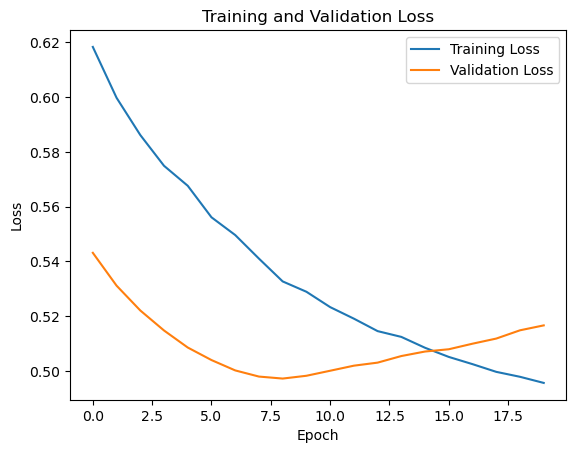

In [14]:
# Plotting the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [15]:
# Target Network
target_model = Sequential()
target_model.add(Dense(64, input_shape=(len(states[0]),), activation='relu'))
target_model.add(Dense(64, activation='relu'))
target_model.add(Dense(len(actions), activation='linear'))
target_model.compile(optimizer='adam', loss='mse')
target_model.set_weights(model.get_weights())  # Initialize target network with current model weights
epoch_rewards=[]


In [16]:
# Initialize epsilon and decay parameters
epsilon = 0.1  # Initial epsilon value, you can adjust this
epsilon_decay = 0.99  # Decay factor for epsilon, adjust as needed

epoch_rewards = []
cumulative_rewards = []  # Store cumulative rewards over epochs

for e in range(20):
    total_epoch_reward = 0
    
    for i in range(len(actions)):
        state = states[i]
        action = epsilon_greedy_action_selection(model, state, actions, epsilon)
        reward = calculate_reward_for_action(state, action)
        next_state = next_states[i]

        replay_memory.push((state, action, reward, next_state))

        # Sample a random mini-batch from replay memory
        batch_size = 32
        if len(replay_memory.memory) >= batch_size:
            transitions = replay_memory.sample(batch_size)
            batch_states, batch_actions, batch_rewards, batch_next_states = zip(*transitions)

            target_q_values = target_model.predict(np.array(batch_next_states))
            max_target_q_values = np.max(target_q_values, axis=1)
            target_q_values_for_actions = batch_rewards + 0.99 * max_target_q_values

            model.fit(np.array(batch_states), target_q_values_for_actions, epochs=1, verbose=0)

    if e % 5 == 0:
        target_model.set_weights(model.get_weights())

    epoch_reward = np.sum([calculate_reward_for_action(states[i], actions[i]) for i in range(len(actions))])
    epoch_rewards.append(epoch_reward)
    cumulative_rewards.append(np.sum(epoch_rewards))  # Calculate cumulative reward

    # Print the reward gained and cumulative reward in this epoch
    print(f'Epoch {e + 1} - Reward: {epoch_reward} - Cumulative Reward: {cumulative_rewards[-1]}')

    # Decay epsilon
    epsilon *= epsilon_decay




1/1 [==============================] - 0s 151ms/step
Epoch 1 - Reward: 20.351457228626142 - Cumulative Reward: 20.351457228626142
1/1 [==============================] - 0s 132ms/step
Epoch 2 - Reward: 14.156863320447101 - Cumulative Reward: 34.50832054907325
1/1 [==============================] - 0s 178ms/step
Epoch 3 - Reward: 12.961168568579568 - Cumulative Reward: 47.46948911765281
1/1 [==============================] - 0s 126ms/step
Epoch 4 - Reward: 17.916101926366395 - Cumulative Reward: 65.38559104401921
1/1 [==============================] - 0s 174ms/step
Epoch 5 - Reward: 21.523174628943703 - Cumulative Reward: 86.90876567296291
1/1 [==============================] - 0s 143ms/step
Epoch 6 - Reward: 31.864340706247944 - Cumulative Reward: 118.77310637921086
1/1 [==============================] - 0s 94ms/step
Epoch 7 - Reward: 35.52432968809479 - Cumulative Reward: 154.29743606730565
1/1 [==============================] - 0s 108ms/step
Epoch 8 - Reward: 50.678192720092454 - Cumu

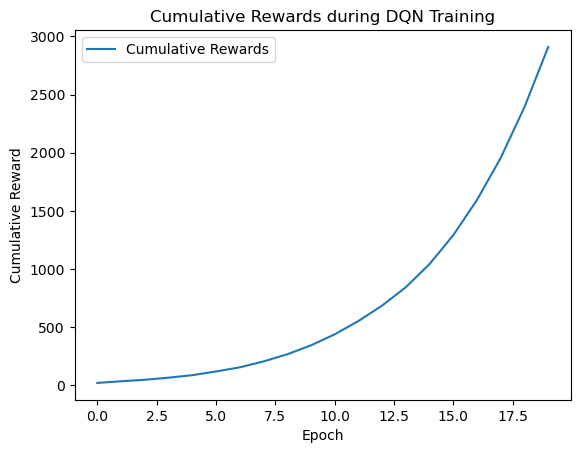

In [17]:
# Plot the cumulative rewards
plt.plot(cumulative_rewards, label='Cumulative Rewards')
plt.xlabel('Epoch')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Rewards during DQN Training')
plt.legend()
plt.show()

In [18]:
epoch_rewards

[20.351457228626142,
 14.156863320447101,
 12.961168568579568,
 17.916101926366395,
 21.523174628943703,
 31.864340706247944,
 35.52432968809479,
 50.678192720092454,
 61.454993872319186,
 76.9568396483339,
 94.56532089218734,
 114.48377465626206,
 133.13174401192796,
 157.7049547317693,
 199.68912852582957,
 248.27482203153684,
 303.1600378767511,
 362.05953425721594,
 436.635228476075,
 516.7365652208906]

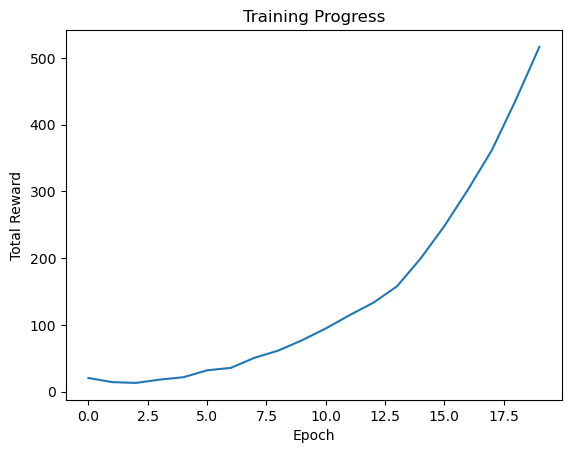

In [19]:
import matplotlib.pyplot as plt
# Plotting the training progress
plt.plot(epoch_rewards)
plt.xlabel('Epoch')
plt.ylabel('Total Reward')
plt.title('Training Progress')
plt.show()

# Q Learning


In [20]:
import numpy as np
import pandas as pd
import random

# Define the Q-learning algorithm
class QLearningAgent:
    def __init__(self, actions, learning_rate=0.001, discount_factor=0.99, exploration_prob=0.5):
        self.actions = actions
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_prob = exploration_prob
        self.q_values = {}

    def get_q_value(self, state, action):
        return self.q_values.get((tuple(state), action), 0.0)

    def update_q_value(self, state, action, reward, next_state):
        best_next_action = max(self.actions, key=lambda a: self.get_q_value(next_state, a))
        new_q_value = (1 - self.learning_rate) * self.get_q_value(state, action) + \
                      self.learning_rate * (reward + self.discount_factor * self.get_q_value(next_state, best_next_action))
        self.q_values[(tuple(state), action)] = new_q_value

    def choose_action(self, state):
        if random.uniform(0, 1) < self.exploration_prob:
            return random.choice(self.actions)
        else:
            return max(self.actions, key=lambda a: self.get_q_value(state, a))

# Initialize Q-learning agent
q_learning_agent = QLearningAgent(actions)



Epoch 1 - Total Reward: 31.9688111379785
Epoch 2 - Total Reward: 6.0569721935856204
Epoch 3 - Total Reward: 8.658331396497923
Epoch 4 - Total Reward: 12.322092749921868
Epoch 5 - Total Reward: 17.131498014785784
Epoch 6 - Total Reward: 23.205472614990295
Epoch 7 - Total Reward: 30.70148702418364
Epoch 8 - Total Reward: 39.81969221953743
Epoch 9 - Total Reward: 50.80843312161122
Epoch 10 - Total Reward: 63.971291453285694
Epoch 11 - Total Reward: 79.67586088432915
Epoch 12 - Total Reward: 98.364514504402
Epoch 13 - Total Reward: 120.56748956060514
Epoch 14 - Total Reward: 146.91868920308536
Epoch 15 - Total Reward: 178.1746882004912
Epoch 16 - Total Reward: 215.2375320985992
Epoch 17 - Total Reward: 259.18204046580337
Epoch 18 - Total Reward: 311.2884686600487
Epoch 19 - Total Reward: 373.0815536527576
Epoch 20 - Total Reward: 446.3771734291928


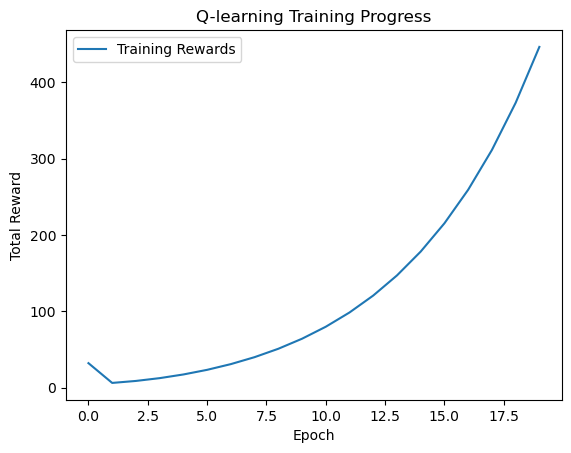

In [21]:


# Q-learning training
training_rewards = []

for epoch in range(20):
    total_reward = 0
    for i in range(len(synthetic_data)):
        state = synthetic_data[i]['state']
        action = synthetic_data[i]['action']
        reward = calculate_reward_for_action(state, action)
        next_state = synthetic_data[i]['next_state']

        # Update Q-values
        q_learning_agent.update_q_value(state, action, reward, next_state)

        total_reward += reward

    training_rewards.append(total_reward)
    print(f'Epoch {epoch + 1} - Total Reward: {total_reward}')

# Plot the training rewards
plt.plot(training_rewards, label='Training Rewards')
plt.xlabel('Epoch')
plt.ylabel('Total Reward')
plt.title('Q-learning Training Progress')
plt.legend()
plt.show()
